In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from statsmodels.tsa.arima.model import ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [2]:
MONTHS = ["JAN", "FEB", "MAR", "APR", "MAY", "JUNE", "JULY", "AUG", "SEP", "OCT", "NOV", "DEC"]
def get_data(path: str):
    data = pd.read_csv(path)
    data["MONTH"] = data["MONTH"].str.strip()
    for i, month in enumerate(MONTHS):
        no = str(i + 1)
        if len(no) == 1:
            no = "0" + no
        data["MONTH"] = data["MONTH"].str.replace(month, no)
    
    data["DATE"] = pd.to_datetime((data["YEAR"].astype(str) + " " + data["MONTH"]), format="%Y %m")
    data.dropna(subset=["PASSENGERS CARRIED"], inplace=True)
    data["PASSENGERS CARRIED"] = data["PASSENGERS CARRIED"].str.replace(',', '').astype(int)
    data.drop(columns=["AIRLINE", "YEAR", "MONTH"], inplace=True)
    data.sort_values("DATE", inplace=True)
    
    out = data[["DATE", "PASSENGERS CARRIED"]].to_numpy()
    out = out.T
    return out

In [3]:
class ForecastStuff:
    TEST_FRAC = 0.2
    FORECAST_MONTHS = 12
    
    def __init__(self, data: np.ndarray, title: str):
        self.data = data
        self.title = title
        self.params = dict(order=(2, 3, 1), seasonal_order=(1, 0, 0, 12), enforce_stationarity=False, enforce_invertibility=False)
        self.Y_LABEL = "Passengers Carried"
        
    
    def display(self, **date_freqs: np.ndarray) -> None:
        plt.figure(figsize=(14, 7))
        for name, date_freq in date_freqs.items():
            plt.plot(date_freq[0], date_freq[1], label=name.replace('_', ' '))
        plt.title(self.title)
        plt.xlabel('Date')
        plt.ylabel(self.Y_LABEL)
        plt.legend()
        plt.show()
    
    def fit(self):
        cutoff = int(self.data.shape[1] * (1 - self.TEST_FRAC))

        train = self.data[:, :cutoff]
        test = self.data[:, cutoff:]
        
        model = ARIMA(list(train[1, :]), **self.params)
        model_fit = model.fit()
        
        predicted = model_fit.forecast(steps=test.shape[1])
        predicted_stuff = test.copy()
        predicted_stuff[1, :] = predicted
        
        self.display(training_data=train, testing_data=test, predicted_data=predicted_stuff)
        
        mase = mean_absolute_scaled_error(test[1, :], predicted, y_train=test[1, :])
        print(f"Mean Absolute Scaled Error (MASE): {mase}")
        
        mape = np.mean(np.abs((test[1, :] - predicted) / test[1, :])) * 100
        print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    
    def forecast(self) -> None:
        model_fore = ARIMA(list(self.data[1, :]), **self.params)
        model_fore_fit = model_fore.fit()
        predicted = model_fore_fit.forecast(steps=self.FORECAST_MONTHS)
        last_date = self.data[0, -1]
        predicted_dates = [last_date + datetime.timedelta(days=30*i) for i in range(1, self.FORECAST_MONTHS + 1)]
        predicted_stuff = np.array([predicted_dates, predicted])
        
        
        self.display(previous_data=self.data, predicted_data=predicted_stuff)

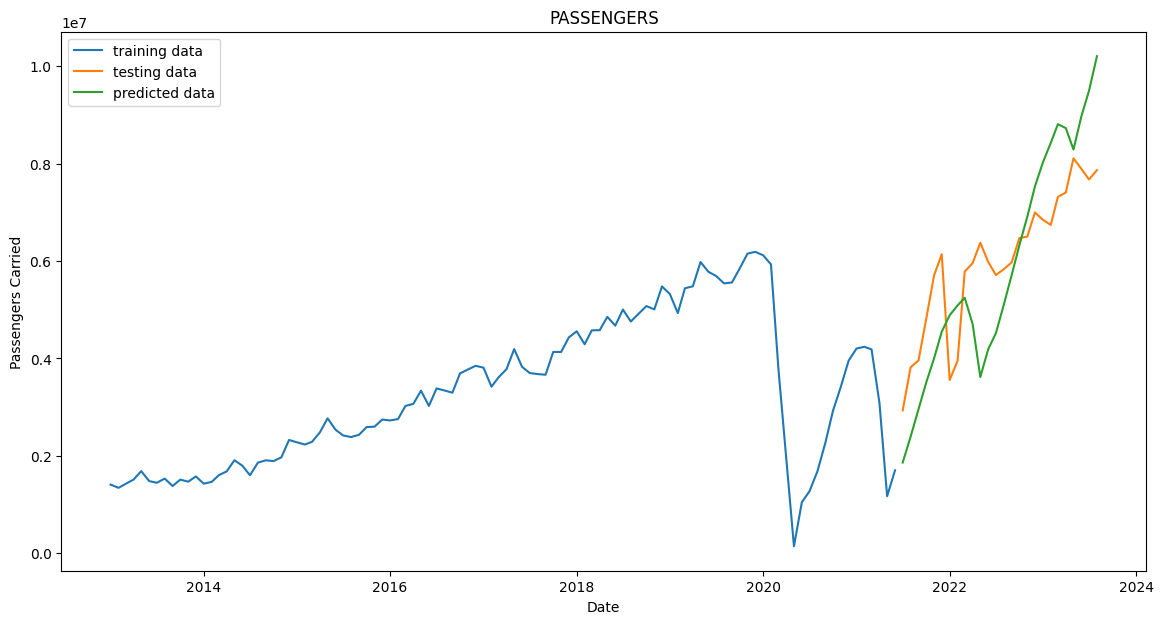

Mean Absolute Scaled Error (MASE): 2.34747126609373
Mean Absolute Percentage Error (MAPE): 21.371328031120782%


In [4]:
forecaster = ForecastStuff(get_data("./air-trafic-prediction/AirtrafficA4.csv"), "PASSENGERS")
forecaster.fit()

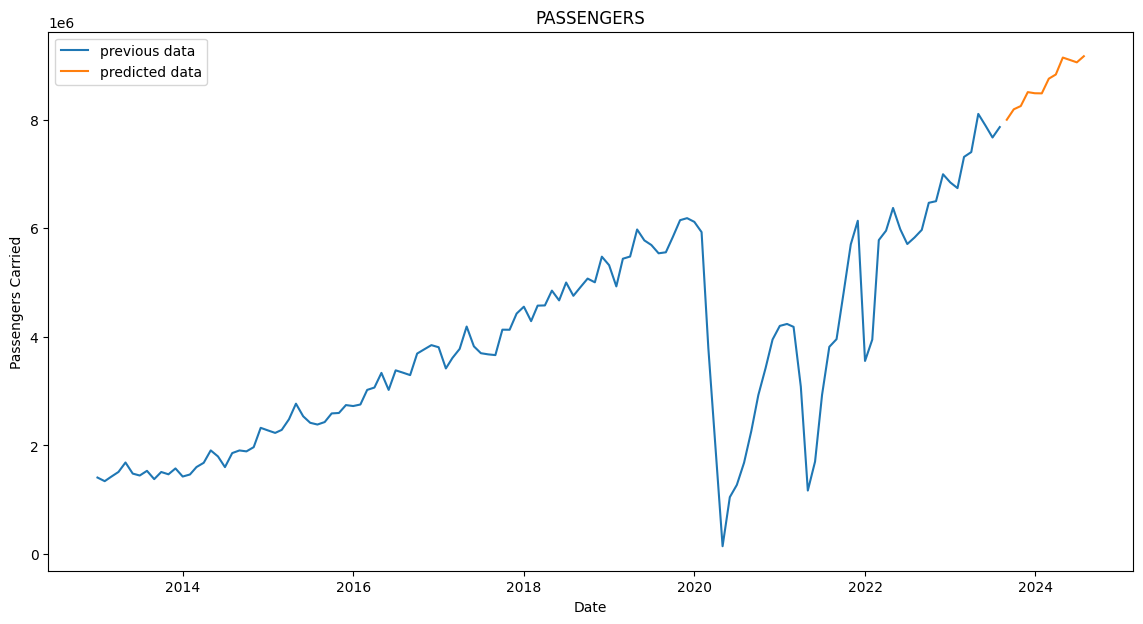

In [5]:
forecaster.forecast()